# ADA - Project Milestone P2
The jupyter notebook presenting our initial results.

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [148]:
# general helpers
def ratio_to_percentage(ratio):
    """
    :param ratio: a number between 0 and 1
    :return: the corresponding percentage with two decimal places
    """
    return round(ratio * 100, 2)

In [149]:
df_ba_users = pd.read_csv("data/BeerAdvocate/users.csv")
df_rb_users = pd.read_csv("data/RateBeer/users.csv")

exp_threshold = 15

df_ba_experienced_users = df_ba_users[df_ba_users["nbr_ratings"] > exp_threshold]
df_rb_experienced_users = df_rb_users[df_rb_users["nbr_ratings"] > exp_threshold]

In [150]:
num_users_ba = len(df_ba_users)
num_exp_users_ba = len(df_ba_experienced_users)
num_users_rb = len(df_rb_users)
num_exp_users_rb = len(df_rb_experienced_users)

perc_ba = 100 - ratio_to_percentage(num_exp_users_ba / num_users_ba)
print("By filtering the datasets, we lost " + str(perc_ba) + "% (" + str(num_users_ba - num_exp_users_ba) + "/" + str(num_users_ba) + ")" + " of the beer advocate dataset")

perc_rb = 100 - ratio_to_percentage(num_exp_users_rb / num_users_rb)
print("By filtering the datasets, we lost " + str(perc_rb) + "% (" + str(num_users_rb - num_exp_users_rb) + "/" + str(num_users_rb) + ")" + " of the beer advocate dataset")

perc_both = round((num_users_ba / (num_users_ba + num_users_rb)) * perc_ba + (num_users_rb  / (num_users_rb + num_users_ba)) * perc_rb, 2)
print("Taking both datasets in account we lost " + str(perc_both) + "% (" + str(num_users_ba + num_users_rb - num_exp_users_ba - num_exp_users_rb) + "/" + str(num_exp_users_ba + num_users_rb) + ")" + " of the users")

By filtering the datasets, we lost 74.84% (115025/153704) of the beer advocate dataset
By filtering the datasets, we lost 80.22% (56295/70174) of the beer advocate dataset
Taking both datasets in account we lost 76.53% (171320/108853) of the users


# Does the reviewer's rating change over time

/var/folders/z0/cqhkbsv975qb9mj7pp6vf0v40000gn/T/ipykernel_40740/1339293572.py:2: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ratings = pd.read_csv("data/matched_beer_data/ratings.csv")
/var/folders/z0/cqhkbsv975qb9mj7pp6vf0v40000gn/T/ipykernel_40740/1339293572.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating_bucket'] = pd.cut(df_filtered['rating'], bins=bucket, right=False, include_lowest=True)
/var/folders/z0/cqhkbsv975qb9mj7pp6vf0v40000gn/T/ipykernel_40740/1339293572.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

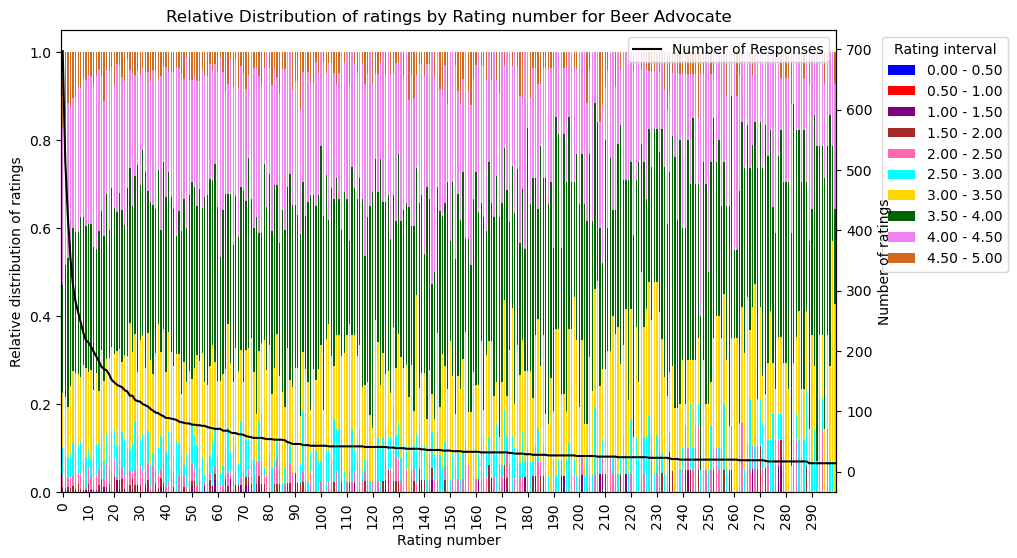

/var/folders/z0/cqhkbsv975qb9mj7pp6vf0v40000gn/T/ipykernel_40740/1339293572.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating_bucket'] = pd.cut(df_filtered['rating'], bins=bucket, right=False, include_lowest=True)
/var/folders/z0/cqhkbsv975qb9mj7pp6vf0v40000gn/T/ipykernel_40740/1339293572.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_amount = df_filtered.groupby(['rating_order', 'rating_bucket']).size().reset_index(name='count')


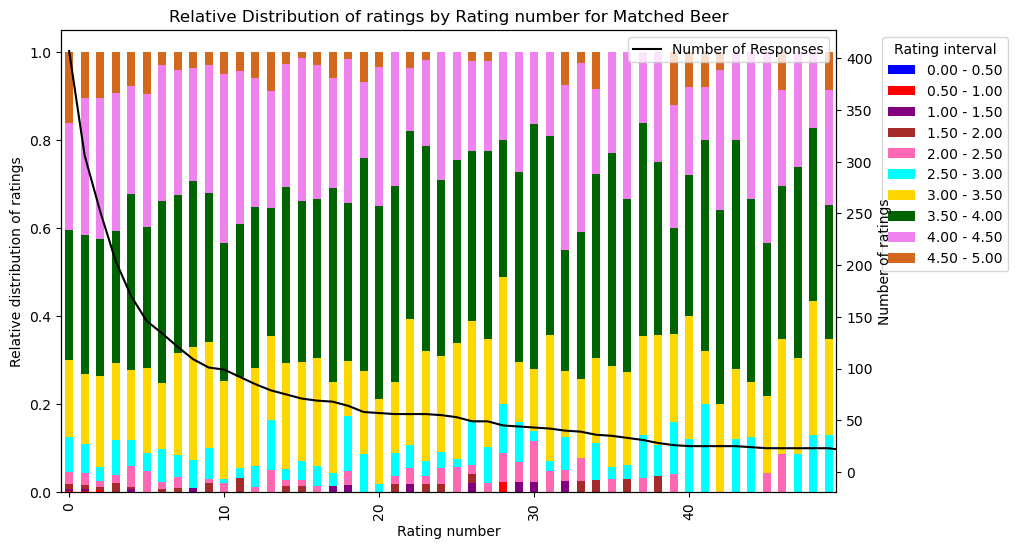

In [213]:
# Loads the dataframe for ratings
df_ratings = pd.read_csv("data/matched_beer_data/ratings.csv")

# Saves a variable for the approproate column names
first_row = df_ratings.iloc[0].values

# Create DataFrame for prefix 'ba' and rename columns
df_ba = df_ratings.filter(like='ba')
df_ba.columns = [first_row[i] for i in range(len(df_ba.columns))] # Assign names from first_row

# Create DataFrame for prefix 'rb' and rename columns
df_rb = df_ratings.filter(like='rb')
df_rb.columns = [first_row[i + len(df_ba.columns)] for i in range(len(df_rb.columns))]  # Assign names from first_row

# Colors for plotting
colors = [
    "blue",
    "red", "purple", "brown", 
    "hotpink", "cyan", 
    "gold", "darkgreen", "violet", "chocolate", "deeppink", "lavender", 
    "darkgray",
]

# Rating buckets to make the plot more readable
rating_buckets = np.arange(0, 5.5, 0.5)

# Function for filtering and diplaying the change in reviewers rating over time
def rating_evolution(df, user_df, df_name, colors=colors, bucket=rating_buckets, nr_reviews=300):
    
    # Cleaning and merging dataframes
    df_cleaned = df.dropna(subset=['rating'])[1:]
    df_cleaned['rating'] = df_cleaned['rating'].astype(float) # tranforms all ratings to int
    df_merged = df_cleaned.merge(user_df, how='inner', on='user_id')
    df_merged[['user_id', 'rating', 'date']].drop_duplicates()
    
    # Sorts the DataFrame by user and date to ensure correct order of ratings and adds column for rating number for respective user
    df_sorted= df_merged.sort_values(by=['user_id', 'date'])
    df_sorted['rating_order'] = df_sorted.groupby('user_id').cumcount() + 1

    # Uses a cutoff for amount of ratings, applies buckets to dataframe and calculates distribution
    df_filtered = df_sorted[df_sorted['rating_order'] <= nr_reviews]
    df_filtered['rating_bucket'] = pd.cut(df_filtered['rating'], bins=bucket, right=False, include_lowest=True)
    df_amount = df_filtered.groupby(['rating_order', 'rating_bucket']).size().reset_index(name='count')
    df_amount['percentage'] = df_amount.groupby('rating_order')['count'].transform(lambda x: x / x.sum())

    # Pivots the data for stacked bar plot
    pivot_df = df_amount.pivot(index='rating_order', columns='rating_bucket', values='percentage').fillna(0)

    # Create the plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # First plot (stacked bar plot for relative distribution)
    pivot_df.plot(kind='bar', stacked=True, ax=ax1, color=colors)
    ax1.set_xlabel('Rating number')
    ax1.set_ylabel('Relative distribution of ratings')
    ax1.set_title('Relative Distribution of ratings by Rating number for ' + df_name)
    ax1.set_xticks(np.arange(0, nr_reviews, 10), np.arange(0, nr_reviews, 10))
    custom_legend_labels = [f"{bucket.left:.2f} - {bucket.right:.2f}" for bucket in pivot_df.columns]
    ax1.legend(title='Rating interval', labels=custom_legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax2 = ax1.twinx()
    # Aggregate the total number of responses for each rating order
    response_count = df_sorted.groupby('rating_order')['user_id'].count()
    ax2.plot(np.arange(0, len(response_count), 1), response_count.values, color='black', linestyle='-', label='Number of Responses')
    ax2.set_ylabel('Number of ratings')
    ax2.legend(loc='upper right')
    plt.show()
    
rating_evolution(df_ba, df_ba_experienced_users, 'Beer Advocate')
rating_evolution(df_rb, df_rb_experienced_users, 'Matched Beer', nr_reviews=50) # seems to be less reviewers with many reviews provided